<a href="https://colab.research.google.com/github/SABER-MOHAMED/TinyML-WindForce/blob/main/wind_force.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# Fréquence d'échantillonnage : 1 Hz (1 mesure/seconde) - adapté au vent
fs = 1
duration = 3600  # 1 heure de données
n_samples = fs * duration

# Générer signal temporel
t = np.arange(n_samples) / fs

# Simuler vitesse du vent avec variations réalistes
base_wind = 5 + 3 * np.sin(2 * np.pi * t / 600)  # Variation lente
turbulence = np.random.normal(0, 1.5, n_samples)  # Turbulence, bruit aléatoire suiviant une loi normale
vitesse_vent = np.clip(base_wind + turbulence, 0, 20) # Limiter entre 0 et 20 m/s

# Rafales = vent + pics aléatoires
vitesse_rafales = vitesse_vent + np.random.gamma(2, 1.5, n_samples)
vitesse_rafales = np.clip(vitesse_rafales, vitesse_vent, 30)

# Créer DataFrame
data = pd.DataFrame({
    'temps': t,
    'vitesse_vent': vitesse_vent,
    'vitesse_rafales': vitesse_rafales
})

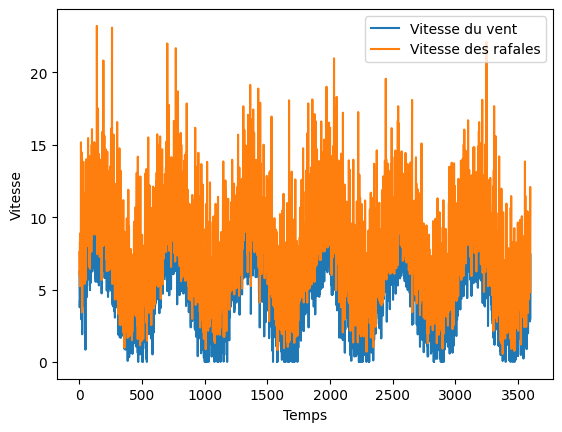

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(data["temps"], data["vitesse_vent"], label="Vitesse du vent")
plt.plot(data["temps"], data["vitesse_rafales"], label="Vitesse des rafales")
plt.xlabel("Temps")
plt.ylabel("Vitesse")
plt.legend()
plt.show()


In [ ]:
window_size = 30
step = 15
features_list = []

for i in range(0, len(data) - window_size, step):
    window = data.iloc[i:i+window_size]

    features = {
        # Statistiques vitesse vent
        'vent_mean': window['vitesse_vent'].mean(),
        'vent_std': window['vitesse_vent'].std(),
        'vent_max': window['vitesse_vent'].max(),
        'vent_min': window['vitesse_vent'].min(),

        # Statistiques rafales
        'rafale_mean': window['vitesse_rafales'].mean(),
        'rafale_max': window['vitesse_rafales'].max(),
        'rafale_std': window['vitesse_rafales'].std(),

        # Indicateurs dérivés
        'diff_rafale_vent': window['vitesse_rafales'].mean() - window['vitesse_vent'].mean(),
        'variabilite': window['vitesse_vent'].diff().abs().mean()
    }
    features_list.append(features)

features_df = pd.DataFrame(features_list)

features_df

,vent_mean,vent_std,vent_max,vent_min,rafale_mean,rafale_max,rafale_std,diff_rafale_vent,variabilite
0,5.365697,1.598807,8.345177,1.910332,8.276495,15.166290,2.980146,2.910798,1.761022
1,5.682080,1.495139,8.345177,1.910332,8.423077,14.467575,2.810440,2.740997,1.856330
2,6.181900,1.691919,9.214823,0.844628,8.794250,13.999574,2.312701,2.612350,1.877628
3,7.221844,1.929144,10.302304,0.844628,10.095909,15.461258,2.135290,2.874065,2.051013
4,7.715683,1.413201,10.302304,4.957905,10.462787,15.461258,1.999167,2.747104,1.470375
...,...,...,...,...,...,...,...,...,...
233,2.693525,1.218503,5.488946,0.399522,5.635037,9.820697,2.233518,2.941512,1.202593
234,2.997712,1.181370,5.706107,0.477722,5.763518,10.062434,2.229106,2.765806,1.465860
235,3.212521,1.611333,6.664035,0.232201,5.515362,10.062434,2.125377,2.302841,2.175513
236,3.306635,1.782498,6.664035,0.232201,6.141160,13.844909,2.887409,2.834525,2.200618


In [ ]:
def compute_score(row):
    # Using column names instead of indices for clarity and correctness
    score = (row['vent_std'] * 0.4 +
             row['vent_max'] * 0.3 +
             row['rafale_max'] * 0.2 +
             row['diff_rafale_vent'] * 0.1)
    return score

def make_labels_from_scores(scores, n_classes=3):
    thresholds = np.percentile(scores, [100 / n_classes * i for i in range(1, n_classes)])
    labels = []
    for score in scores:
        label = sum(score > t for t in thresholds)
        labels.append(label)
    return labels

# Calculer scores
scores = []
for idx, row in features_df.iterrows():
    score = compute_score(row)  # Pass the row directly, not row.values
    scores.append(score)

# Générer labels (3 classes)
labels = make_labels_from_scores(scores, n_classes=3)
# 0 = calme, 1 = modéré, 2 = fort
features_df['label'] = labels
features_df

,vent_mean,vent_std,vent_max,vent_min,rafale_mean,rafale_max,rafale_std,diff_rafale_vent,variabilite,label
0,5.365697,1.598807,8.345177,1.910332,8.276495,15.166290,2.980146,2.910798,1.761022,1
1,5.682080,1.495139,8.345177,1.910332,8.423077,14.467575,2.810440,2.740997,1.856330,1
2,6.181900,1.691919,9.214823,0.844628,8.794250,13.999574,2.312701,2.612350,1.877628,1
3,7.221844,1.929144,10.302304,0.844628,10.095909,15.461258,2.135290,2.874065,2.051013,2
4,7.715683,1.413201,10.302304,4.957905,10.462787,15.461258,1.999167,2.747104,1.470375,2
...,...,...,...,...,...,...,...,...,...,...
233,2.693525,1.218503,5.488946,0.399522,5.635037,9.820697,2.233518,2.941512,1.202593,0
234,2.997712,1.181370,5.706107,0.477722,5.763518,10.062434,2.229106,2.765806,1.465860,0
235,3.212521,1.611333,6.664035,0.232201,5.515362,10.062434,2.125377,2.302841,2.175513,0
236,3.306635,1.782498,6.664035,0.232201,6.141160,13.844909,2.887409,2.834525,2.200618,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Préparer les données pour l'entraînement

# Séparer les features (X) et les labels (y)
X = features_df.drop('label', axis=1)  # Remove the label column
y = features_df['label'].values  # Use the label column as target

# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Normalisation (fitter sur train uniquement)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Sauvegarder paramètres pour déploiement
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Modèle de base
def create_model(n_neurons=16, activation='relu', learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(n_neurons, activation=activation, input_shape=(9,)),
        keras.layers.Dense(8, activation=activation),
        keras.layers.Dense(3, activation='softmax')  # 3 classes
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Function create_model définie avec succès!")

Function create_model définie avec succès!


In [ ]:
# Note: Le modèle sera entraîné avec PRUNING dans la cellule suivante
# Cette cellule est conservée pour référence mais n'est pas exécutée dans le pipeline final

print("Passez à la cellule suivante pour l'entraînement avec PRUNING")

# ============================================
# ENTRAÎNEMENT AVEC PRUNING
# ============================================
# Ce notebook utilise PRUNING pendant l'entraînement
# Passez à la cellule suivante pour démarrer l'entraînement

print("✓ Données préparées")
print("✓ Fonction create_model définie")
print("\n➡️ Exécutez la cellule suivante pour l'entraînement avec PRUNING")

Passez à la cellule suivante pour l'entraînement avec PRUNING
✓ Données préparées
✓ Fonction create_model définie

➡️ Exécutez la cellule suivante pour l'entraînement avec PRUNING


In [ ]:
# ============================================
# PRUNING PENDANT L'ENTRAÎNEMENT
# ============================================
import tensorflow_model_optimization as tfmot

print("Préparation du modèle avec Pruning...")

# Créer un nouveau modèle (non entraîné) pour le pruning
model_for_pruning = create_model(n_neurons=16, activation='relu')

# Configurer les paramètres de pruning
num_train_samples = len(X_train_scaled)
batch_size = 32
epochs_pruning = 40
steps_per_epoch = num_train_samples // batch_size

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,      # Commencer sans pruning
        final_sparsity=0.5,         # Retirer 50% des poids à la fin
        begin_step=0,
        end_step=steps_per_epoch * epochs_pruning
    )
}

# Appliquer le pruning AVANT l'entraînement
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model_for_pruning, **pruning_params)

# Compiler le modèle
pruned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Entraînement avec Pruning ({epochs_pruning} epochs)...")

# Callbacks nécessaires pour le pruning
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),  # OBLIGATOIRE pour le pruning
]

# Entraîner le modèle AVEC pruning
history_pruned = pruned_model.fit(
    X_train_scaled, y_train,
    batch_size=batch_size,
    epochs=epochs_pruning,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)

Préparation du modèle avec Pruning...
Entraînement avec Pruning (40 epochs)...
Epoch 1/40
6/6 [==============================] - 2s 48ms/step - loss: 1.1223 - accuracy: 0.3253 - val_loss: 1.2041 - val_accuracy: 0.3333
Epoch 2/40
6/6 [==============================] - 0s 11ms/step - loss: 1.0751 - accuracy: 0.4337 - val_loss: 1.1591 - val_accuracy: 0.3611
Epoch 3/40
6/6 [==============================] - 0s 10ms/step - loss: 1.0381 - accuracy: 0.5060 - val_loss: 1.1277 - val_accuracy: 0.3611
Epoch 4/40
6/6 [==============================] - 0s 9ms/step - loss: 1.0125 - accuracy: 0.5361 - val_loss: 1.1029 - val_accuracy: 0.3889
Epoch 5/40
6/6 [==============================] - 0s 9ms/step - loss: 0.9916 - accuracy: 0.5542 - val_loss: 1.0821 - val_accuracy: 0.3889
Epoch 6/40
6/6 [==============================] - 0s 9ms/step - loss: 0.9737 - accuracy: 0.5542 - val_loss: 1.0621 - val_accuracy: 0.3889
Epoch 7/40
6/6 [==============================] - 0s 9ms/step - loss: 0.9569 - accuracy: 0

In [ ]:
# Retirer les wrappers de pruning pour obtenir le modèle final
# pruned_model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)

# print("\n" + "="*50)
# print("MODÈLE AVEC PRUNING - Performance")
# print("="*50)
# test_loss_pruned, test_acc_pruned = pruned_model_stripped.evaluate(X_test_scaled, y_test, verbose=0)
# print(f"Test Accuracy: {test_acc_pruned:.4f}")
# print(f"Test Loss: {test_loss_pruned:.4f}")
# print(f"Nombre de paramètres: {pruned_model_stripped.count_params():,}")

# Après avoir strippé le pruning
pruned_model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)

# RECOMPILER le modèle
pruned_model_stripped.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Maintenant vous pouvez l'évaluer
print("MODÈLE AVEC PRUNING - Performance")
print("="*50)
test_loss_pruned, test_acc_pruned = pruned_model_stripped.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_acc_pruned:.4f}")
print(f"Test Loss: {test_loss_pruned:.4f}")

MODÈLE AVEC PRUNING - Performance
Test Accuracy: 0.7778
Test Loss: 0.6444


In [ ]:
# Tuning hyperparamètres
from sklearn.model_selection import GridSearchCV
# (implémenter grid search sur n_neurons, learning_rate, epochs...)


# Modèle avec QAT + Pruning
import tensorflow_model_optimization as tfmot



# Pruning
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
}
# model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(best_model, **pruning_params)

# # QAT
# qat_model = tfmot.quantization.keras.quantize_model(model_for_pruning)
# qat_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# qat_model.fit(X_train_scaled, y_train, epochs=30, validation_data=(X_val_scaled, y_val))

# ============================================
# POST-TRAINING QUANTIZATION (PTQ) sur le modèle PRUNÉ
# ============================================

print("\nConversion du modèle PRUNÉ en TFLite avec Quantization...")

# Fonction représentative pour la quantization
def representative_dataset():
    """Génère des données représentatives pour la quantization"""
    for i in range(100):
        # Utiliser des échantillons d'entraînement
        yield [X_train_scaled[i:i+1].astype(np.float32)]

# Convertir le modèle PRUNÉ en TFLite avec quantization complète
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_stripped)

# Configuration pour quantization complète INT8
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

# Sauvegarder le modèle quantifié
with open('model_pruned_quantized.tflite', 'wb') as f:
    f.write(tflite_model_quant)

print(f"Modèle TFLite quantifié sauvegardé: model_pruned_quantized.tflite")
print(f"Taille du modèle quantifié: {len(tflite_model_quant) / 1024:.2f} KB")

# Évaluer le modèle TFLite quantifié
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fonction pour évaluer le modèle TFLite
def evaluate_tflite_model(interpreter, X_test, y_test):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    correct = 0
    for i in range(len(X_test)):
        # Quantifier l'entrée
        input_data = X_test[i:i+1].astype(np.float32)
        input_data_quantized = (input_data / input_scale + input_zero_point).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], input_data_quantized)
        interpreter.invoke()

        # Obtenir la sortie quantifiée
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # Déquantifier
        output_data_dequantized = (output_data.astype(np.float32) - output_zero_point) * output_scale

        pred_class = np.argmax(output_data_dequantized)
        if pred_class == y_test[i]:
            correct += 1

    return correct / len(X_test)

tflite_accuracy = evaluate_tflite_model(interpreter, X_test_scaled, y_test)

print("\n" + "="*50)
print("MODÈLE PRUNÉ + QUANTIFIÉ (PTQ) - Performance")
print("="*50)
print(f"Test Accuracy: {tflite_accuracy:.4f}")
print(f"Taille: {len(tflite_model_quant) / 1024:.2f} KB")


Conversion du modèle PRUNÉ en TFLite avec Quantization...
Modèle TFLite quantifié sauvegardé: model_pruned_quantized.tflite
Taille du modèle quantifié: 3.39 KB

MODÈLE PRUNÉ + QUANTIFIÉ (PTQ) - Performance
Test Accuracy: 0.7500
Taille: 3.39 KB


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
